In [21]:
from requests import get
from json import loads
import time
import pandas as pd
from tqdm.notebook import trange, tqdm 
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
import mtg_toolbox as mtg_tools

In [176]:
#card_request = "Propeller Pioneer" # carte de base

#card_request = "Agadeem's Awakening" #mdfc land/spell
#card_request = "Jadzi, Oracle of Arcavios" #mdfc spell/spell
#card_request = "Bonecrusher Giant / Stomp" #adventure
#card_request = "claim-fame" #split card
#card_request = "Delver of Secrets" #double-faced spell/spell (free)
#card_request = "Search for Azcanta" #double faced spell/land (free)
#card_request = "Arlinn, the Pack's Hope" #double faced daybound (free)
#card_request = "Behold the Unspeakable" #saga (free)
#card_request = "Hostile Hostel" #double faced land/spell (free)
#card_request = "Malevolent Hermit" #double face disturb (with mana cost) 
#card_request = "Akki Lavarunner" #flip card

card_request = "Bruna, the Fading Light" #meld => 1 seul face

In [177]:
card = loads(get(f"https://api.scryfall.com/cards/named?fuzzy={card_request}").text)

In [178]:
card["card_faces"]

KeyError: 'card_faces'

In [179]:
card["cmc"]

7.0

In [180]:
card.keys()

dict_keys(['object', 'id', 'oracle_id', 'multiverse_ids', 'mtgo_id', 'tcgplayer_id', 'cardmarket_id', 'name', 'lang', 'released_at', 'uri', 'scryfall_uri', 'layout', 'highres_image', 'image_status', 'image_uris', 'mana_cost', 'cmc', 'type_line', 'oracle_text', 'power', 'toughness', 'colors', 'color_identity', 'keywords', 'all_parts', 'legalities', 'games', 'reserved', 'foil', 'nonfoil', 'finishes', 'oversized', 'promo', 'reprint', 'variation', 'set_id', 'set', 'set_name', 'set_type', 'set_uri', 'set_search_uri', 'scryfall_set_uri', 'rulings_uri', 'prints_search_uri', 'collector_number', 'digital', 'rarity', 'flavor_text', 'card_back_id', 'artist', 'artist_ids', 'illustration_id', 'border_color', 'frame', 'frame_effects', 'security_stamp', 'full_art', 'textless', 'booster', 'story_spotlight', 'edhrec_rank', 'penny_rank', 'prices', 'related_uris', 'purchase_uris'])

In [181]:
card["oracle_text"]

'When you cast this spell, you may return target Angel or Human creature card from your graveyard to the battlefield.\nFlying, vigilance\n(Melds with Gisela, the Broken Blade.)'

In [182]:
"card_faces" in card.keys()

False

In [97]:
time.sleep(0.01)

### Parse deck

In [146]:
file = "Listes/double_face_list.txt" 
with open(file) as f:
    lines = f.readlines()

In [147]:
decklist = {"nom":[],"cmc":[],"text":[],"mana_cost":[],"type":[]}
for l in tqdm(lines):
    line = l.split("\n")[0]
    nb_card = int(line[0])
    card = line[2:]
    card = loads(get(f"https://api.scryfall.com/cards/named?fuzzy={card}").text)
    
    for _ in range(nb_card):
        if "card_faces" in card.keys() :
            for face in card["card_faces"] :
                try:
                    decklist["nom"].append(face["name"])
                    decklist["cmc"].append(mtg_tools.compute_cmc(face["mana_cost"]))
                    decklist["text"].append(face["oracle_text"])
                    decklist["mana_cost"].append(face["mana_cost"])
                    decklist["type"].append(face["type_line"])
                except KeyError:
                        #TODO EDGE CASE: treat double face cards
                        print("error on : ", face["name"])
        else :
            try:
                decklist["nom"].append(card["name"])
                decklist["cmc"].append(card["cmc"])
                decklist["text"].append(card["oracle_text"])
                decklist["mana_cost"].append(card["mana_cost"])
                decklist["type"].append(card["type_line"])
            except KeyError:
                #TODO EDGE CASE: treat double face cards
                print("error on : ", card["name"])
    time.sleep(0.01)

  0%|          | 0/6 [00:00<?, ?it/s]

In [148]:
#print(decklist)

In [149]:
deck_df = pd.DataFrame(decklist)

In [150]:
deck_df

,nom,cmc,text,mana_cost,type
0,Badlands,0.0,({T}: Add {B} or {R}.),,Land — Swamp Mountain
1,Bomat Courier,1.0,"Haste\nWhenever Bomat Courier attacks, exile t...",{1},Artifact Creature — Construct
2,Bonecrusher Giant,3.0,Whenever Bonecrusher Giant becomes the target ...,{2}{R},Creature — Giant
3,Stomp,2.0,Damage can't be prevented this turn. Stomp dea...,{1}{R},Instant — Adventure
4,Agadeem's Awakening,3.0,Return from your graveyard to the battlefield ...,{X}{B}{B}{B},Sorcery
5,"Agadeem, the Undercrypt",0.0,"As Agadeem, the Undercrypt enters the battlefi...",,Land
6,Claim,1.0,Return target creature card with mana value 2 ...,{B},Sorcery
7,Fame,2.0,Aftermath (Cast this spell only from your grav...,{1}{R},Sorcery
8,Mayor of Avabruck,2.0,Other Human creatures you control get +1/+1.\n...,{1}{G},Creature — Human Advisor Werewolf
9,Howlpack Alpha,0.0,Each other creature you control that's a Werew...,,Creature — Werewolf


In [151]:
cmc = []
for i in range(len(deck_df)):
    if "Land" in deck_df["type"].iloc[i]:
        pass
    elif "NA" in deck_df["type"].iloc[i]:
        pass
    else:
        cmc.append(int(deck_df["cmc"].iloc[i]))

(array([1., 0., 0., 2., 0., 0., 3., 0., 0., 2.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

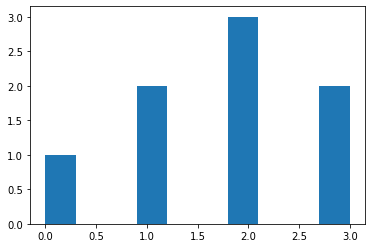

In [152]:
plt.hist(cmc)

<AxesSubplot:ylabel='Count'>

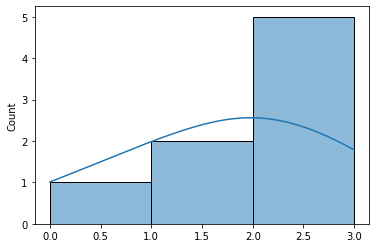

In [153]:
sns.histplot(data=cmc, kde=True, binwidth=1)